In [1]:
#Importing relevant packages 
import numpy as np
import pandas as pd

import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#Importing NLTK
import nltk

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore


/Users/kajsarosenblad/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# TOPIC MODELLING 

In this lab, we will apply a 50-topic LDA model to tweets from US Members of Congress to examine discussions about COVID-19 by Democrats and Republicans over time. Who was quicker to set the agenda around COVID-19, Democrats or Republicans? Make a guess if you know something about US politics.

The dataset is similar to last week's scaling lab and has been preprocessed similarly, with the main exception being that this time tweets are subsetted from 2019 and later, because we are mainly interested in tweets that (may) capture the COVID-19 crisis. The preprocessed dataset is called 'MOCTweets_preprocessed.csv'. 

#### If you wish to replicate the preprocessing, these are the steps taken for this dataset:

1. Changing 'date' from str type object to datetime type 
2. Subsetting to 2019 and later 
3. Removing unneeded columns (all except 'date', 'text', 'affiliation', and 'nominate_name')
2. Removing duplicated tweets 
7. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
7. Removing instances of "&amp"
8. Replacing all remaining "&" with "and"
8. Removing odd special characters that show up in topic model ("┻","┃","━","┳","┓","┏","┛")
9. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Replacing "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
6. Removing "RT" and "via"
11. Removing mentions (@someone)
10. Removing numbers, removing punctuation (except hyphens and #), removing separators, removing urls, lowercasing, removing stopwords, lemmatizing, and stemming.


### 1: Preparing the data for topic modelling

The preprocessed data includes columns for date, affiliation, nominate name, tweet text, and two columns of preprocessed tweet text: one stemmed and one lemmatized. We will be using the stemmed text today. 

1. Import the dataframe
2. Convert 'date' from str type object to datetime type 
3. Similar to last week, replace NaN values with an empty string in the stemmed text. Then use `groupby` and `agg` to group the data by *date* and *affiliation*, and aggregate the stemmed tweet text within each of these categories into one long string. You do not need to save the nominate names. 
4. For each row, tokenize the stemmed text data into unigrams. Consider using NLTK's `TweetTokenizer`, which is made to handle e.g. hashtags and emojis.
5. For each row, use `nltk.bigrams` to create bigrams from the unigrams. This function will return a list of tuples. Connect the two words in each bigram tuple with an underscore to get a list of bigram tokens. E.g.: [(great, news), (news, presid), (presid, signatur)] --> ['great_news', 'news_presid', 'presid_signatur']
6. For each row, combine the unigrams and bigrams in one cell to create a list of all unigram and bigram tokens in that row.


In [2]:
#Importing the data
tweets = pd.read_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

In [3]:
tweets.head()

,Unnamed: 0,date,text,affiliation,nominate_name,text_lemma,text_stemmed
0,0,2019-03-19,Federal government employees are dedicated pub...,Republican,"BOOZMAN, John",federal government employee dedicate public se...,feder govern employe dedic public servant prov...
1,7,2019-09-13,.@DeptVetAffairs recently rolled out a new dig...,Republican,"BOOZMAN, John",recently roll new digital memorial platform mi...,recent roll new digit memori platform million ...
2,10,2019-09-12,I know the importance of empowering women in t...,Republican,"BOOZMAN, John",know importance empower woman global economy s...,know import empow women global economi sponsor...
3,17,2019-03-22,It was great to spend some time with leaders i...,Republican,"BOOZMAN, John",great spend time leader van buren county talk ...,great spend time leader van buren counti talk ...
4,18,2019-09-18,"For 72 years, @usairforce has been blazing the...",Republican,"BOOZMAN, John",year blaze trail dominance air space cyberspac...,year blaze trail domin air space cyberspac dad...


In [4]:
#convert to datetime
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y-%m-%d', errors = 'ignore')

In [5]:
#remove Nan
tweets['text_stemmed'] = tweets['text_stemmed'].replace(np.nan, '', regex=True)

In [6]:
#aggregate data on date and affiliation
tweets_agg = tweets.groupby(['date','affiliation'])['text_stemmed'].agg(','.join).reset_index()

In [7]:
#tokenize text
tk = nltk.TweetTokenizer()

tweets_agg['text_stemmed'] = [tk.tokenize(item) for item in tweets_agg['text_stemmed']]

In [8]:
def bigrams(column):

    combined = []
    
    for i,j in list(nltk.bigrams(column)):
        bigram = i + '_' + j
        combined.append(bigram)
    return combined

In [9]:
#create bigrams
tweets_agg['bigrams'] = [bigrams(item) for item in tweets_agg['text_stemmed']]

In [11]:
tweets_agg['combined'] = tweets_agg['text_stemmed'] + tweets_agg['bigrams']

### 2: Creating a corpus object

We will be using the `gensim` module to create a corpus object and filter very frequent and in-frequent words. Read the documentation here: https://radimrehurek.com/gensim/corpora/dictionary.html 

1. Create a dictionary mapping between words and their ids. This code is provided for you. This can take a couple of seconds.  
2. Use `filter_extremes` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10 documents).
3. You can inspect the vocabulary using either `id2token` or `token2id`. 
4. Create a corpus object. Essentially, use `doc2bow` in a list comprehension to create a list containing a bag of words for each document (aka for each row in the dataframe). Each bag of words should be a list containing tuples with 1) an index indicating the word and 2) the frequency of that word. The code will look like: `corpus = [id2word.doc2bow(doc) for doc in df['tokens']]`.


In [27]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['combined']) 

#Viewing how many words are in our vocabulary
print(len(id2word))

2800894


In [28]:
#filter extremes
id2word.filter_extremes(no_below=10, no_above=0.999, keep_n = None)
print(len(id2word))

127208


In [29]:
#create corpus
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['combined']]

### 3: Topic modelling

We will run topic modelling using an LDA implementation from the `gensim` module. You can find the documentation here: https://radimrehurek.com/gensim/models/ldamulticore.html 

We will investigate the results of a model with 50 topics. However, like last week, this takes several hours to run. Therefore, first try the LDA algorithm with approx. 10 topics and then download the pre-trained model to investigate the 50-topic results.

1. Run the LDA algorithm with the provided code
2. The typical way to get a sense of what each topic actually is means looking at the tokens that are most predictive for each topic. Use `print_topics` to see the 10 (or more) most predictive tokens for each topic. Optional: When using `print_topics`, the model weights are included. If you want to clean this, you can use regex to filter out everything but the words.


**A note on setting parameters:**

- Passes and iterations: As this is just a test run, passes and iterations are set quite low. If you want to use topic modelling in your project, you should make sure to set passes and iterations high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000. 
- Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001


**A note on choosing the number of topics:**
Choosing the number of topics is not straightforward. Both Barberá (2019) and Munger (2019) use 10-fold cross-validation for the log-likelihood and perplexity. If you want to implement these models in your own work and want to learn how to do this, read about hyperparameter tuning [here](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2) or contact Greg who can guide you in R. 

At the same time, there is no statistic that can tell you how many topics you want: "There is often a negative relationship between the best-fitting model and the substantive information provided" (Grimmer and Stewart 2013). So in the end it is a judgment call on the side of the researcher, which can be guided by statistics.

If topics repeat themselves, this may suggest that we chose too many topics for the dataset. 


In [30]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes = 1, iterations = 50)


In [23]:
#Disabling logging again
logging.disable(sys.maxsize)

In [32]:
lda_model.print_topics()

[(0,
  '0.004*"presid" + 0.004*"peopl" + 0.004*"trump" + 0.004*"hous" + 0.003*"act" + 0.003*"protect" + 0.003*"im" + 0.003*"need" + 0.003*"bill" + 0.003*"famili"'),
 (1,
  '0.004*"presid" + 0.003*"need" + 0.003*"trump" + 0.003*"protect" + 0.003*"act" + 0.003*"hous" + 0.003*"im" + 0.003*"support" + 0.003*"famili" + 0.003*"nation"'),
 (2,
  '0.003*"act" + 0.003*"presid" + 0.003*"need" + 0.003*"peopl" + 0.003*"trump" + 0.003*"famili" + 0.003*"im" + 0.002*"pass" + 0.002*"right" + 0.002*"new"'),
 (3,
  '0.004*"hous" + 0.003*"presid" + 0.003*"commun" + 0.003*"nation" + 0.003*"trump" + 0.003*"famili" + 0.003*"-" + 0.003*"act" + 0.002*"congress" + 0.002*"countri"'),
 (4,
  '0.004*"trump" + 0.004*"presid" + 0.003*"hous" + 0.003*"famili" + 0.003*"support" + 0.003*"act" + 0.003*"need" + 0.003*"nation" + 0.003*"bill" + 0.003*"day"'),
 (5,
  '0.004*"trump" + 0.003*"peopl" + 0.003*"congress" + 0.003*"presid" + 0.003*"famili" + 0.003*"join" + 0.003*"nation" + 0.003*"health" + 0.003*"senat" + 0.003*"m

### 4.1: Investigating results: beta parameters

To investigate the results, load the pre-trained models with the provided code. 

Retrieve the estimated **beta parameters** from the model. There is a beta per token per topic. A beta indicates how predictive a token is of a document being assigned to a specific topic. 

1. Beta values can be accessed using either `get_topic_terms` (where you input the topic and number of most predictive tokens you want returned) or `get_topics` (which returns the full matrix of beta values). 
2. Pick two or three topics (in the solution code the topics 1, 8, 16, 27, 28, 29, 31, 41, 47, 48 were chosen for visualization). Get the 10 highest beta values and plot these in a horizontal barchart with `sns.barplot`, where x is the beta probability and y is the token. 

**Hint**: Create a dataframe from the matrix generated by `get_topics` with token names as the column names. Tokens can be retrieved with the `id2word.token2id`. Once you have the dataframe, `nlargest` can be used on a specific row to get the columns with the *n* largest values in that row. 

**Intended take-away**: The "top terms" for each topic are just the tokens that have the largest beta. 

**A note on the results**: You may notice that some topics have an even distributions of probabilities for all terms. This may be because the `minimum_probability` parameter is not low enough, because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, or because we have set the number of topics too high for the data. For your own projects, experiment with the parameters.

In [42]:
#Importing the pre-trained models

path ='/Users/kajsarosenblad/Documents/SODAS/Advanced Data Science 2/week 3/Topic_model/'

lda_model=pickle.load(open(path+'ldamodel_50t100p1000i000001minprob.sav', 'rb'))
corpus=pickle.load(open(path+'corpus_50t100p1000i000001minprob.sav', 'rb'))
id2word=pickle.load(open(path+'id2word_50t100p1000i000001minprob.sav', 'rb'))


In [69]:
#make df with probabilities and words
df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))

In [72]:
pd.options.display.float_format = '{:20,.10f}'.format

df.head()

,#,#_prioriti,#actonclim,#articlesofimpeach,#ashantialert,#az,#ca,#climatechang,#congress,#enoughisenough,...,#covidー,coronaviru_fund,spread_#covid,#coronaviru_fund,#covid_-,coronaviru_covid,emerg_#coronaviru,often_soap,#coronaviru_#covid,avoid_touch
0,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,...,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177
1,0.0000807007,0.0000003125,0.0000198639,0.0000003125,0.0000003125,0.0000306145,0.0000003125,0.0001091940,0.0000003125,0.0000003125,...,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125,0.0000003125
2,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,...,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177
3,0.0003221107,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0002198963,0.0000144571,0.0000000599,0.0000923247,0.0000000599,...,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599,0.0000000599
4,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,...,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177,0.0000079177


In [112]:
#first topic
first = df.iloc[1].nlargest(10)

x = first.values
y = first.index

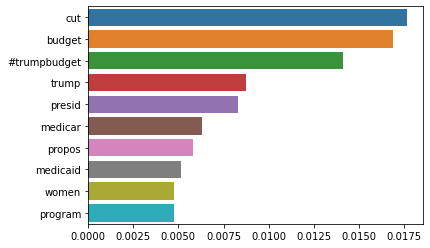

In [113]:
sns.barplot(x,y)

### 4.2: Investigating results: gamma parameters

Retrieve the estimated **gamma parameters** from the model. For each document, you will get a list of topics with an associated gamma. The gammas indicate the probability (or amount) that a document is about a specific topic.

1. Use `get_document_topics` with the full corpus to get lists of probabilities for each document. Set `minimum_probability = 0.0`. The code will be: `lda_model.get_document_topics(corpus, minimum_probability = 0.0)`. Make this a list. 
2. Save the probabilities in the original dataframe. You can find inspiration for how to do this in the pseudo-code:

**Pseudo-code to save the probabilities in the original dataframe:**

Use list comprehension to create a list of 50 topic names (e.g. topic_1, topic_2 etc.)

Create a dataframe filled with zeros of the shape (number of documents - 864, number of topics - 50) and with columns = the list of 50 topic names. 

For each index, document in the list of gamma probabilities: <br>
<font color=white>0000</font>for each topic-probability pair in the document: <br>
<font color=white>00000000</font>locate index and column with that topic name and save the probability

Concatenate this dataframe with the original dataframe over axis 1.



In [201]:
gamma = list(lda_model.get_document_topics(corpus, minimum_probability = 0.0))

In [253]:
document_topics = list(lda_model.get_document_topics(corpus))

In [254]:
#Creating a list of names for all 50 topics
topics = ['topic_{}'.format(t) for t in range(0,50)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),50)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [255]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,date,affiliation,text_stemmed,bigrams,combined,topic_0,topic_1,topic_2,topic_3,topic_4,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,2019-01-01,Democrat,"[tragedi, great, news, presid, signatur, tonig...","[tragedi_great, great_news, news_presid, presi...","[tragedi, great, news, presid, signatur, tonig...",0.0000040036,0.0000040036,0.0000040036,0.0000040036,0.0000040036,...,0.0000040036,0.0000040036,0.0000040036,0.0000040036,0.1166141406,0.0000040036,0.0000040036,0.0000040036,0.0000040036,0.0000040036
1,2019-01-01,Republican,"[happi, healthi, prosper, #happynewyear, #, k,...","[happi_healthi, healthi_prosper, prosper_#happ...","[happi, healthi, prosper, #happynewyear, #, k,...",0.0000098014,0.0000098014,0.0000098014,0.1109791324,0.0000098014,...,0.0000098014,0.0000098014,0.0000098014,0.0000098014,0.2077576369,0.0000098014,0.0000098014,0.0000098014,0.0000098014,0.0000098014
2,2019-01-02,Democrat,"[amen, ,, supervisor, told, wont, get, paid, b...","[amen_,, ,_supervisor, supervisor_told, told_w...","[amen, ,, supervisor, told, wont, get, paid, b...",0.0000022513,0.0000022513,0.0000022513,0.0000022513,0.0000022513,...,0.0000022513,0.0000022513,0.0000022513,0.0000022513,0.0019891364,0.0000022513,0.0000022513,0.0000022513,0.0000022513,0.0000022513
3,2019-01-02,Republican,"[see, mr, alright, alright, alright, sidelin, ...","[see_mr, mr_alright, alright_alright, alright_...","[see, mr, alright, alright, alright, sidelin, ...",0.0000052214,0.0000052214,0.0000052214,0.2008715570,0.0000052214,...,0.0000052214,0.0000052214,0.0000052214,0.0000052214,0.0034422667,0.0000052214,0.0000052214,0.0000052214,0.0000052214,0.5588358641
4,2019-01-03,Democrat,"[shutdown, pay, freez, feder, govern, suffer, ...","[shutdown_pay, pay_freez, freez_feder, feder_g...","[shutdown, pay, freez, feder, govern, suffer, ...",0.0000009560,0.0000009560,0.0000009560,0.0000009560,0.0000009560,...,0.1620800346,0.0000009560,0.0000009560,0.0000009560,0.0008875149,0.0000009560,0.0000009560,0.0000009560,0.0000009560,0.0000009560


### 5: Visualizing the development of the coronavirus related topic 

Getting back to the original question: How has the topic of coronavirus progressed on Twitter among Members of Congress over time? 

1. Use `print_topics` to look through the 10 most relevant words of each topic and identify the topic related to coronavirus. 
2. If it is not already, convert the date column from string type to datetime type
3. Graph the development of the coronavirus topic over time. Create a plot where x = date, y = the covid topic, and hue = affiliation. 
4. Do the same with a subset of the dataset only including 2020. 

Can you see which party was quicker to set the agenda around COVID-19? 


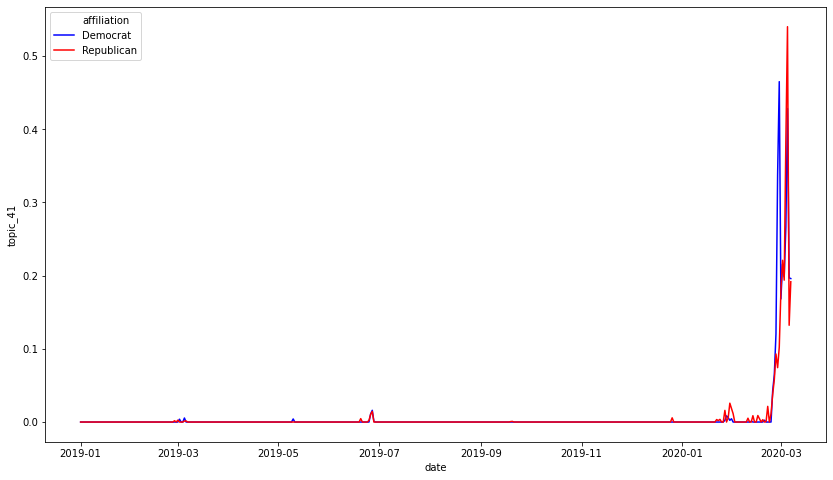

In [259]:
plt.figure(figsize = (14,8))
sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df, palette = ['blue', 'red'])